In [121]:
import os
import pandas as pd

from glob import glob  
from natsort import natsorted, ns

import geopy
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import rasterio  
from rasterio.plot import show
from pyproj import Transformer
from rasterio.windows import Window
import rioxarray 

import imageio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from osgeo import gdal
from mayavi import mlab

import webbrowser
from IPython.display import Image


In [122]:
def get_tif(path):
    #Function to get all tif files and sort them
    tif_file =[]
    files = glob(path,recursive = True) 
    for file in files: 
        tif_file.append(file)
    tif_file = natsorted(tif_file, alg=ns.IGNORECASE)     
    return tif_file

In [123]:
dsm_path = './Map_files/DSM/**/*.tif'
DSM_tif = get_tif(dsm_path)
DSM_tif[:3]

['./Map_files/DSM/DHMVIIDSMRAS1m_k01/GeoTIFF/DHMVIIDSMRAS1m_k01.tif',
 './Map_files/DSM/DHMVIIDSMRAS1m_k02/GeoTIFF/DHMVIIDSMRAS1m_k02.tif',
 './Map_files/DSM/DHMVIIDSMRAS1m_k03/GeoTIFF/DHMVIIDSMRAS1m_k03.tif']

In [124]:
dtm_path = './Map_files/DTM/**/*.tif'
DTM_tif = get_tif(dtm_path)
DTM_tif[:3]

['./Map_files/DTM/DHMVIIDTMRAS1m_k01/GeoTIFF/DHMVIIDTMRAS1m_k01.tif',
 './Map_files/DTM/DHMVIIDTMRAS1m_k02/GeoTIFF/DHMVIIDTMRAS1m_k02.tif',
 './Map_files/DTM/DHMVIIDTMRAS1m_k03/GeoTIFF/DHMVIIDTMRAS1m_k03.tif']

In [103]:
address = "Abbaye de Bonne-Espérance"

In [104]:
def get_lat_long(address):
    # Function to get the longitude and latitude of the address
    locator = Nominatim(user_agent="my_app")
    location = locator.geocode(address)
    house_lat_long = [location.latitude, location.longitude]
    return house_lat_long

def house_map(func):
    #plot the address 
    house_map = folium.Map(location=func,zoom_start=50)
    folium.Marker(location=func,popup=get_lat_long(address)).add_to(house_map)
    return house_map 

house_map(get_lat_long(address))

In [105]:
lat,lon = get_lat_long(address)
lat,lon

(45.1278038, 0.2143643)

In [106]:
def transform(lon, lat):
    # transform to Belgium 'EPSG:31370' coordinate
    transformer = Transformer.from_crs("EPSG:4326", crs_to = 'EPSG:31370' ,always_xy=True)
    xx, yy = transformer.transform(lon, lat)
    print(f'longitude:{xx} latitude:{yy}' )
    
    return xx,yy

In [107]:
xx,yy = transform(lon, lat)

longitude:-178022.73554976008 latitude:-456822.26028827485


In [108]:
path = './House_address/Belgium_houses_address.csv'

In [109]:
def get_coordinate(path,address):
    
    index = []
    
    df = pd.read_csv(path)
    
    for i in range(df.shape[0]):
        
        if df['Address'][i] == address :
            index.append(i)
            break
        continue

    xx, yy = df['EPSG:31370_x'][index][index[0]] ,df['EPSG:31370_y'][index][index[0]] 

    lat, lon = df['EPSG:4326_lat'][index][index[0]] ,df['EPSG:4326_lon'][index][index[0]] 
    
    return (xx, yy) , (lat, lon)

In [62]:
(xx, yy) , (lat, lon) = get_coordinate(path,address)

In [110]:
xx, yy

(-178022.73554976008, -456822.26028827485)

In [111]:
lat, lon

(45.1278038, 0.2143643)

In [112]:
def bounds(tifs):
#Creating bounding box
    
    bounds = []
    
    for i in tifs:
        src = rasterio.open(i)
        bounds.append(src.bounds)
        
    return  bounds 

In [113]:
src_bounds = bounds(DSM_tif)
src_bounds[:3]

[BoundingBox(left=145000.0, bottom=238000.0, right=162000.0, top=247000.0),
 BoundingBox(left=162000.0, bottom=238000.0, right=194000.0, top=250000.0),
 BoundingBox(left=194000.0, bottom=238000.0, right=206000.0, top=248000.0)]

In [119]:
# check which tif contains the location in DSM

def check_DSM_flb(xx,yy):
    
    scr_path = []

    for i,bound in enumerate(src_bounds,1):

        if (xx >= bound[0] and xx <= bound[2]) & \
           (yy >= bound[1] and yy <= bound[3]):
            scr_path.append('./Map_files/DSM/DHMVIIDSMRAS1m_k0'+ str(i) +'/GeoTIFF/DHMVIIDSMRAS1m_k0'+ str(i) + '.tif')  

            print('The house is in this tif :', 'DHMVIIDSMRAS1m_k' + str(i) + '.tif')
        else:
            None
            
    return scr_path

In [120]:
dsm_path_flb = check_DSM_flb(xx,yy)

In [116]:
dsm_path_flb

[]

In [117]:
# check which tif contains the location in DTM


def check_DTM_flb(xx,yy):
    
    scr_path = []

    for i,bound in enumerate(src_bounds,1):

        if (xx >= bound[0] and xx <= bound[2]) & \
           (yy >= bound[1] and yy <= bound[3]):

            scr_path.append('./Map_files/DTM/DHMVIIDTMRAS1m_k0'+ str(i) +'/GeoTIFF/DHMVIIDTMRAS1m_k0'+ str(i) + '.tif')  

            print('The house is in this tif :', 'DHMVIIDTMRAS1m_k' + str(i) + '.tif')
        else:
            None
            
    return scr_path
dtm_path_flb = check_DTM_flb(xx,yy)

In [118]:
dtm_path_flb[0]

IndexError: list index out of range

In [72]:
def clip_dsm(path,window_size:int):
 
    xds = rioxarray.open_rasterio(path,masked=True,chunks=True)
    
    # set window size
    n = window_size

    # create coordinates and geometries
    coor1,coor2 = [(xx-n),(yy+n)],[(xx+n),(yy+n)]

    coor3,coor4 = [(xx+n),(yy-n)] ,[(xx-n),(yy-n)]
    print('coordinate3&4',coor3,coor4)

    geometries = [ {'type': 'Polygon', 'coordinates': [[coor1,coor2, coor3,coor4,coor1 ]]}]

    # clip the image as per the geometries size
    clipped = xds.rio.clip(geometries)
    
    # save clip
    clip_dsm = clipped.rio.to_raster(address+"_clipped_dsm.tif",tiled=True, dtype="int32")

    return clipped.plot()

In [91]:
def clip_dtm(path,window_size:int):
 
    xds = rioxarray.open_rasterio(path,masked=True,chunks=True)
    
    # set window size
    n = window_size

    # create coordinates and geometries
    coor1,coor2 = [(xx+n),(yy-n)],[(xx-n),(yy-n)]

    coor3,coor4 = [(xx-n),(yy+n)] ,[(xx+n),(yy+n)]

    geometries = [ {'type': 'Polygon', 'coordinates': [[coor1,coor2, coor3,coor4,coor1 ]]}]
    print("geometries",geometries)

    # clip the image as per the geometries size
    clipped = xds.rio.clip(geometries)

    
    # save clip
    clip_dtm = clipped.rio.to_raster(address +"_clipped_dtm.tif",tiled=True, dtype="int32")

    return clipped.plot()

coordinate3&4 [164303.39, 219877.74] [164263.39, 219877.74]


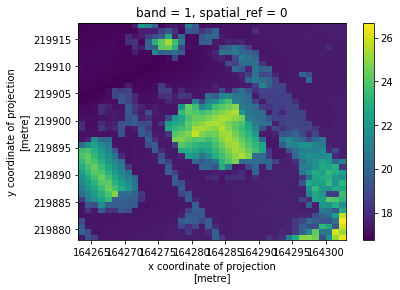

In [92]:
clip_dsm(dsm_path_flb[0],20)

geometries [{'type': 'Polygon', 'coordinates': [[[164303.39, 219877.74], [164263.39, 219877.74], [164263.39, 219917.74], [164303.39, 219917.74], [164303.39, 219877.74]]]}]


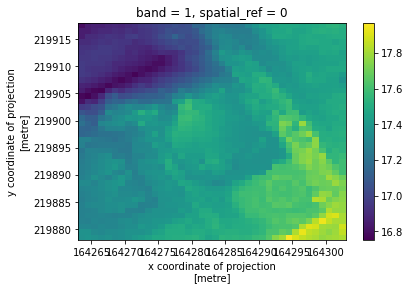

In [93]:
clip_dtm(dtm_path_flb[0],20)

In [94]:
def chm_tif():
    
    # open the digital terrain model 
    with rasterio.open(address +'_clipped_dtm.tif') as src:
        lidar_dtm_im = src.read(1, masked=True)
        dtm_meta = src.profile
        
    # open the digital surface model 
    with rasterio.open(address +'_clipped_dsm.tif') as src:
        lidar_dsm_im = src.read(1, masked=True)
        dsm_meta = src.profile
    
    # calculate canopy height model
    lidar_chm = lidar_dsm_im - lidar_dtm_im
    
    # change directory
    #os.chdir(flandre_path)
    
    # save chm clipped 
    with rasterio.open(address +'_clipped_chm.tif', 'w', **dsm_meta) as ff:
        ff.write(lidar_chm,1)
        
    chm_tif = address +'_clipped_chm.tif'
    
    return chm_tif

In [95]:
def House_3D(tif,size:int,azim=215):

    chm = imageio.imread(tif)

    nx,ny = chm.shape

    x = np.linspace(0, size*2, nx)
    y = np.linspace(0, size*2, ny)

    yv,xv = np.meshgrid(x, y)

    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')

    chm3d=ax.plot_surface(xv,yv,chm,cmap='plasma',linewidth=0)
    ax.set_title('CHM(Canopy Height Model)')
    ax.set_xlabel('Distance (m)')
    ax.set_ylabel('Distance (m)')
    ax.set_zlabel('Elevation (m)')
    ax.view_init(azim=azim)
        
    fig.colorbar(chm3d, shrink=0.3, aspect=10);
    fig.savefig(address +'_3D.png', dpi=200) 
    
    return  plt.show()

In [96]:
print(chm_tif())

Gramyelaan 24 2960 Brecht_clipped_chm.tif


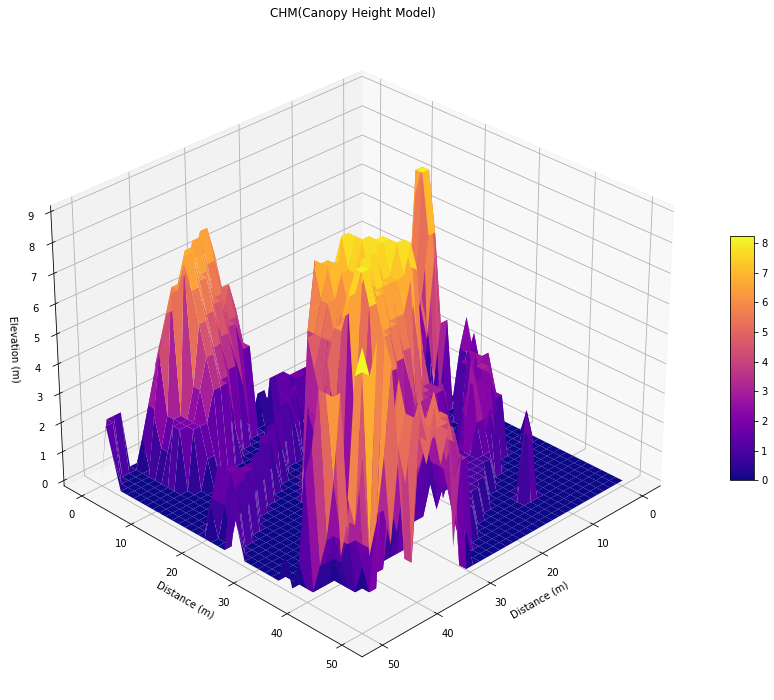

In [97]:
House_3D(chm_tif(),25,45)


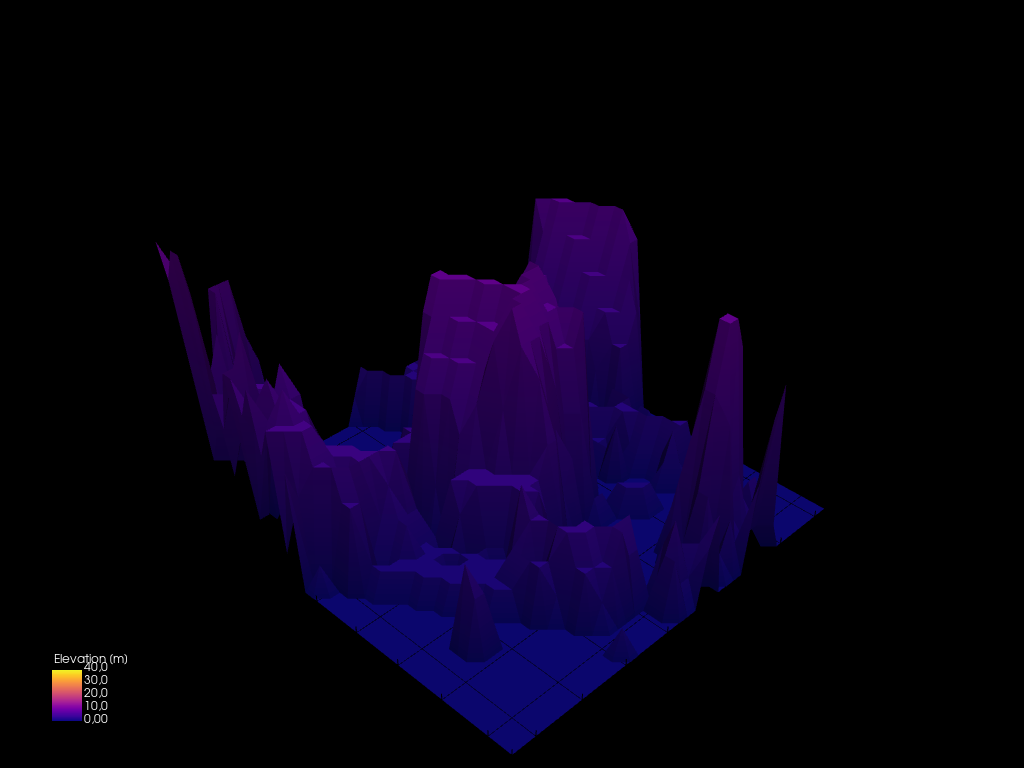

In [102]:
import gemgis as gg
import pyvista as pv

img = 'Gramyelaan 24 2960 Brecht_clipped_chm.tif'
mesh = gg.visualization.read_raster(path=img,nodata_val=9999.0,name='Elevation [m]')

topo = mesh.warp_by_scalar(scalars="Elevation [m]", factor=3.0)

#sargs = dict(fmt="%.0f", color='black')
sargs = dict(height=0.1, vertical=True, position_x=0.05, position_y=0.05)
#sargs = dict(interactive=True)

p = pv.Plotter(notebook=True)
p.add_mesh(mesh=topo, cmap='plasma', scalar_bar_args=sargs, clim=[-0, 40])
#p.add_mesh(mesh=topo, cmap='gist_ncar', scalar_bar_args=sargs, clim=[-0, 40])
p.set_background('black')
p.show_grid(color='black')
p.show()
# Remove from plotters so output is not produced in docs
pv.plotting._ALL_PLOTTERS.clear()

In [38]:
import lidario as lio
# Translate a raster to a numpy point cloud.
fb = r'Gramyelaan 11 2960 Brecht_clipped_chm.tif'
translator = lio.Translator("geotiff", "np")
point_cloud_tif = translator.translate(fb)

In [39]:
type(point_cloud_tif)

numpy.ndarray

In [40]:
point_cloud_tif.shape

(1600, 3)

In [41]:
import pyvista

/home/biniam/anaconda3/envs/pygdal38/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


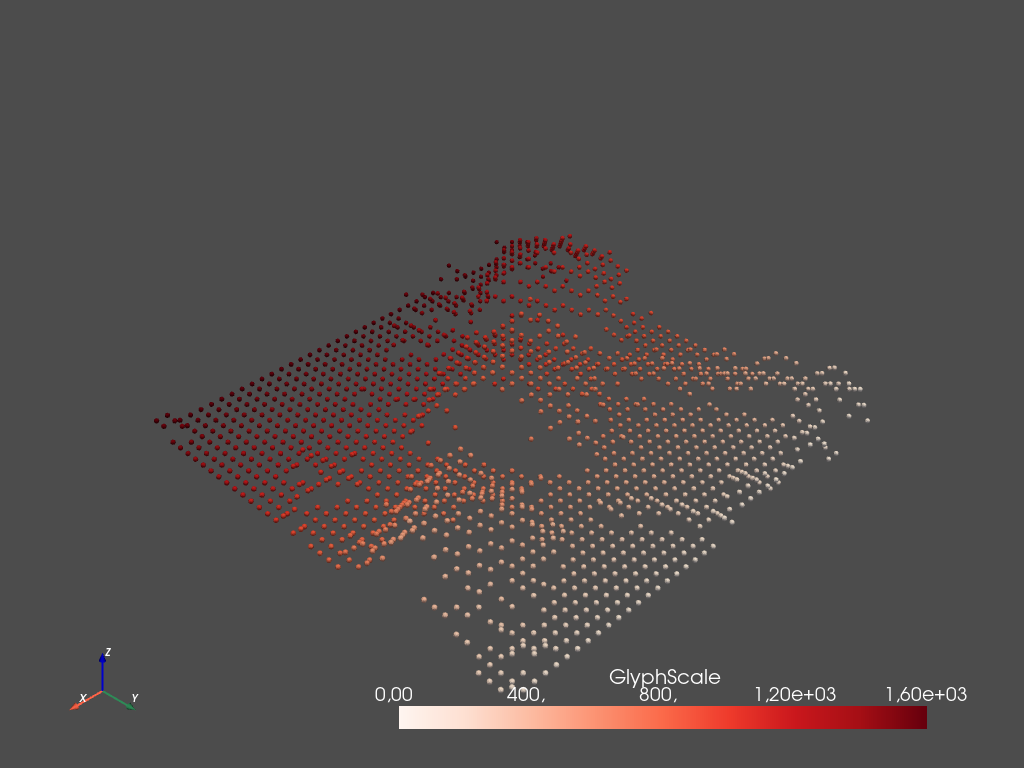

In [42]:
pdata = pyvista.PolyData(point_cloud_tif)
pdata['orig_sphere'] = np.arange(1600)

# create many spheres from the point cloud
sphere = pyvista.Sphere(radius=0.2, phi_resolution=20, theta_resolution=20)
pc = pdata.glyph(scale=False, geom=sphere)
pc.plot(cmap='Reds')

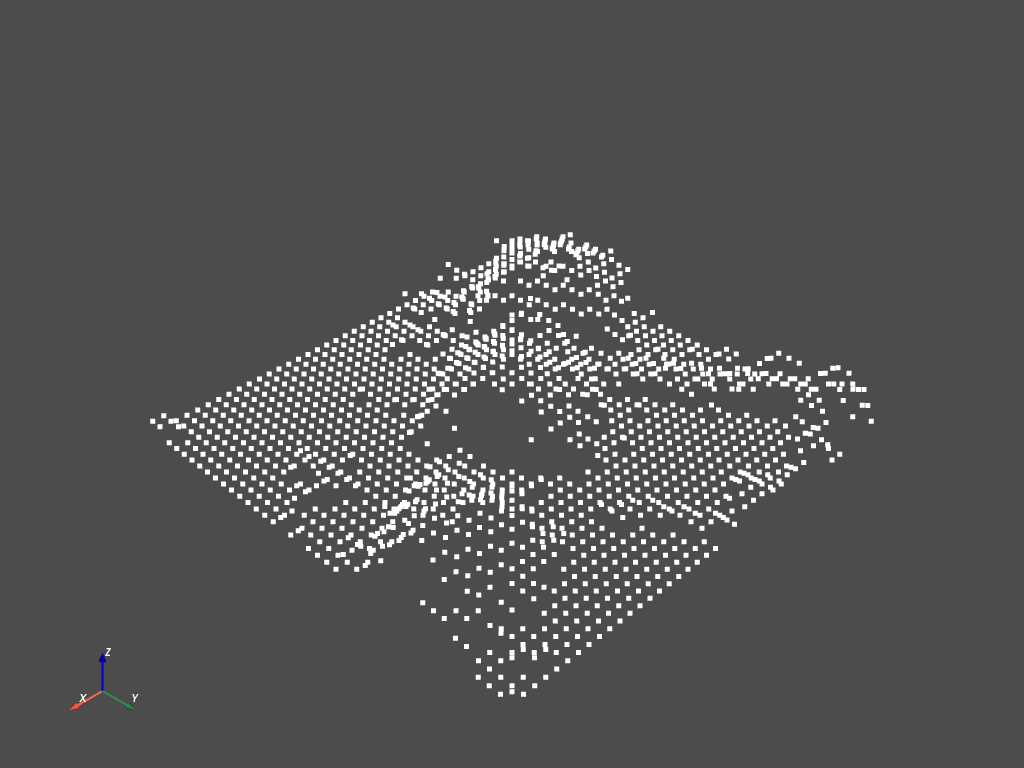

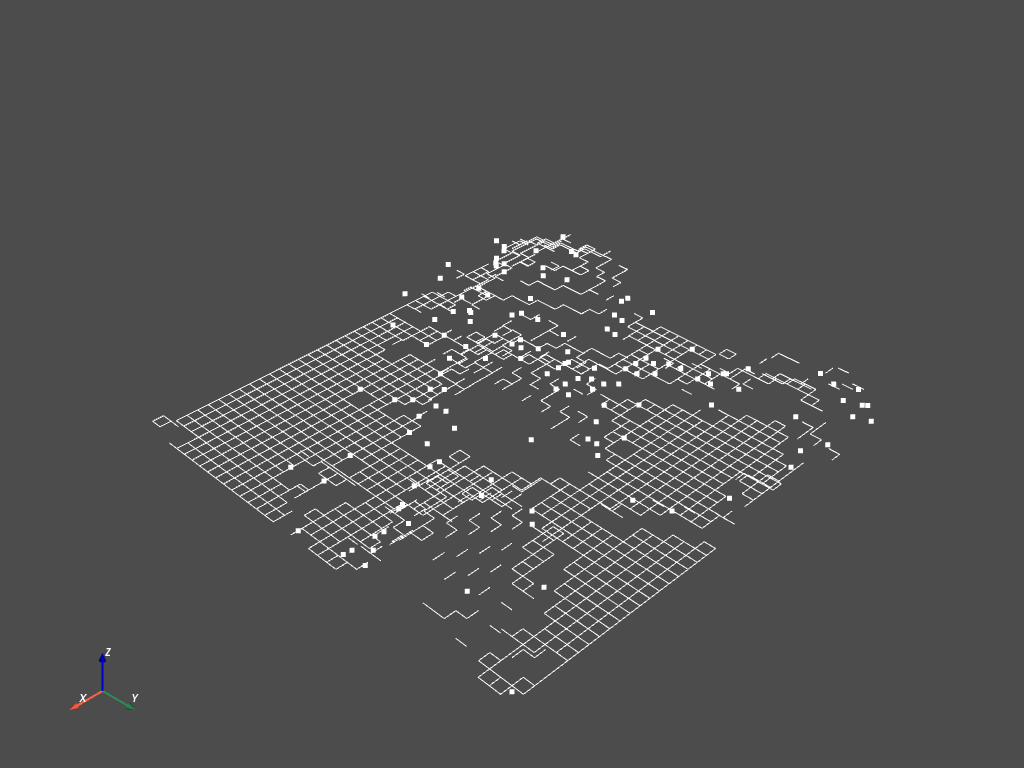

In [54]:
import numpy as np
import pyvista as pv

# points is a 3D numpy array (n_points, 3) coordinates of a sphere
cloud = pv.PolyData(point_cloud_tif)
cloud.plot()

volume = cloud.delaunay_3d(alpha=0.7)
shell = volume.extract_geometry()
shell.plot()



In [60]:
import gemgis as gg
import pyvista as pv

In [129]:
fb = r'Gramyelaan 11 2960 Brecht_clipped_dtm.tif'

mesh = gg.visualization.read_raster(path=fb,
                                    nodata_val=9999.0,
                                    name='Elevation [m]')

In [130]:
mesh

StructuredGrid (0x7f307126cee0)
  N Cells:	1521
  N Points:	1600
  X Bounds:	1.642e+05, 1.642e+05
  Y Bounds:	2.199e+05, 2.199e+05
  Z Bounds:	0.000e+00, 0.000e+00
  Dimensions:	40, 40, 1
  N Arrays:	1

In [131]:
dem = rasterio.open(fb)
dem.read(1)

array([[16, 16, 16, ..., 17, 17, 17],
       [16, 16, 16, ..., 17, 17, 17],
       [16, 16, 16, ..., 17, 17, 17],
       ...,
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16],
       [16, 16, 16, ..., 16, 16, 16]], dtype=int32)

In [140]:
dem.height

40

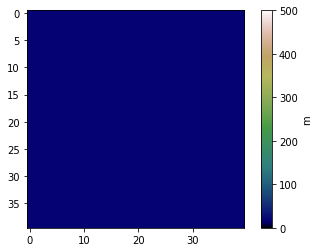

In [132]:
im = plt.imshow(dem.read(1), cmap='gist_earth', vmin=0, vmax=500)
cbar = plt.colorbar(im)
cbar.set_label('m')

In [133]:
topo = mesh.warp_by_scalar(scalars="Elevation [m]", factor=5.0)

topo

StructuredGrid (0x7f30711fbf40)
  N Cells:	1521
  N Points:	1600
  X Bounds:	1.642e+05, 1.642e+05
  Y Bounds:	2.199e+05, 2.199e+05
  Z Bounds:	8.000e+01, 8.500e+01
  Dimensions:	40, 40, 1
  N Arrays:	1

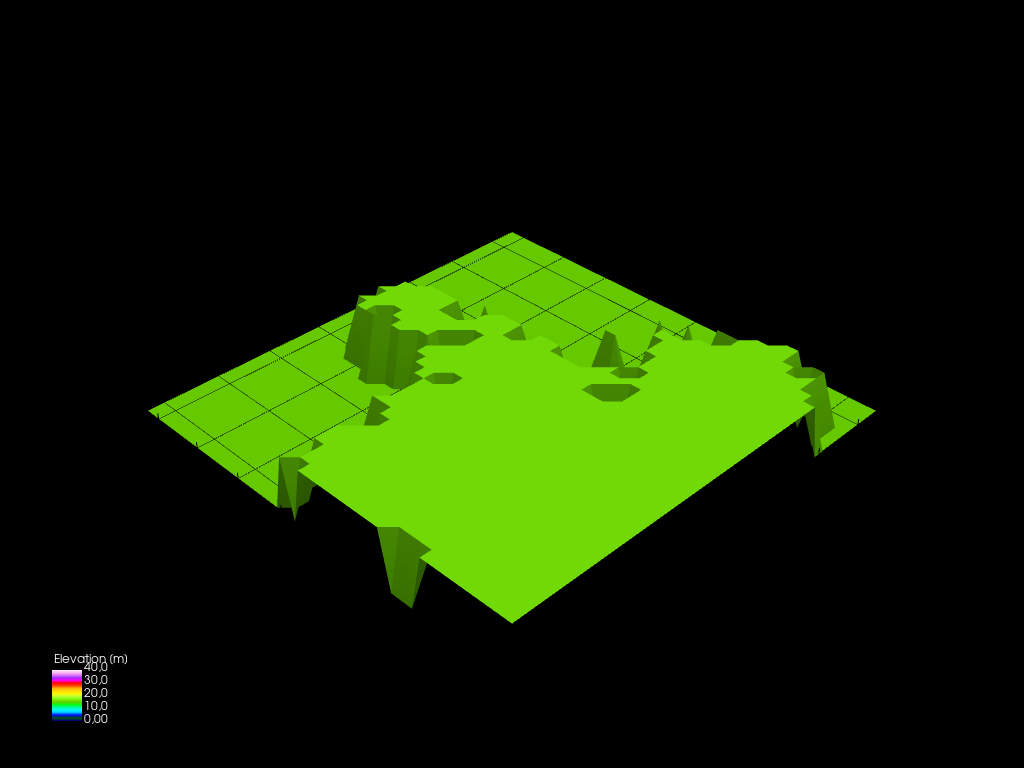

In [143]:
#sargs = dict(fmt="%.0f", color='black')
sargs = dict(height=0.1, vertical=True, position_x=0.05, position_y=0.05)
#sargs = dict(interactive=True)

p = pv.Plotter(notebook=True)
p.add_mesh(mesh=topo, cmap='gist_ncar', scalar_bar_args=sargs, clim=[-0, 40])
p.add_mesh(mesh=topo, cmap='gist_ncar', scalar_bar_args=sargs, clim=[-0, 40])
p.set_background('black')
p.show_grid(color='black')
p.show()
# Remove from plotters so output is not produced in docs
pv.plotting._ALL_PLOTTERS.clear()

In [150]:
dem = rasterio.open(fb)
dem.read(1)

array([[17, 19, 21, ..., 17, 17, 18],
       [18, 20, 21, ..., 17, 17, 17],
       [19, 21, 20, ..., 18, 17, 17],
       ...,
       [18, 18, 18, ..., 16, 17, 16],
       [16, 18, 16, ..., 16, 17, 17],
       [16, 17, 18, ..., 16, 17, 17]], dtype=int32)

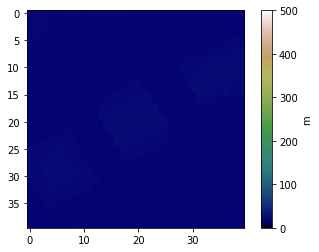

In [151]:
im = plt.imshow(dem.read(1), cmap='gist_earth', vmin=0, vmax=500)
cbar = plt.colorbar(im)
cbar.set_label('m')

In [152]:
topo = mesh.warp_by_scalar(scalars="Elevation [m]", factor=5.0)

topo

StructuredGrid (0x7f3070833ac0)
  N Cells:	1521
  N Points:	1600
  X Bounds:	1.642e+05, 1.642e+05
  Y Bounds:	2.199e+05, 2.199e+05
  Z Bounds:	8.000e+01, 1.250e+02
  Dimensions:	40, 40, 1
  N Arrays:	1

In [1]:
#sargs = dict(fmt="%.0f", color='black')
sargs = dict(height=0.1, vertical=True, position_x=0.05, position_y=0.05)
#sargs = dict(interactive=True)

p = pv.Plotter(notebook=True)
p.add_mesh(mesh=topo, cmap='plasma', scalar_bar_args=sargs, clim=[-0, 40])
p.add_mesh(mesh=topo, cmap='gist_ncar', scalar_bar_args=sargs, clim=[-0, 40])
p.set_background('black')
p.show_grid(color='black')
p.show()
# Remove from plotters so output is not produced in docs
pv.plotting._ALL_PLOTTERS.clear()

NameError: name 'pv' is not defined